## Visualising CNN layers
This notebook is about visualising aspects of CNNs that I find interesting and was curious to learn more about. Let's begin! ☠ ☠

In [1]:
from fastai import *
from fastai.vision.all import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
path = Path('../input/ranzcr-clip-catheter-line-classification')
# All labels train
train_all_lab = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv').drop(columns = "PatientID")
# Condensed labels train
ann = pd.read_csv("../input/ranzcr-clip-catheter-line-classification/train_annotations.csv")[['StudyInstanceUID', 'label']]
ann['StudyInstanceUID'] = ann['StudyInstanceUID']+ ".jpg"
ann.columns = ['name', 'label']
# Converting the input to multilabel
ann = ann.sort_values(['name', 'label']).groupby('name')['label'].unique().agg({'label': ';'.join}).reset_index().drop(columns = "level_0")

# EDA

The dataset contains images about the position and presence of catheters and tubes in medical images. The following categories are present:
* ETT - Abnormal - endotracheal tube placement abnormal
* ETT - Borderline - endotracheal tube placement borderline abnormal
* ETT - Normal - endotracheal tube placement normal
* NGT - Abnormal - nasogastric tube placement abnormal
* NGT - Borderline - nasogastric tube placement borderline abnormal
* NGT - Incompletely Imaged - nasogastric tube placement inconclusive due to imaging
* NGT - Normal - nasogastric tube placement borderline normal
* CVC - Abnormal - central venous catheter placement abnormal
* CVC - Borderline - central venous catheter placement borderline abnormal
* CVC - Normal - central venous catheter placement normal
* Swan Ganz Catheter Present

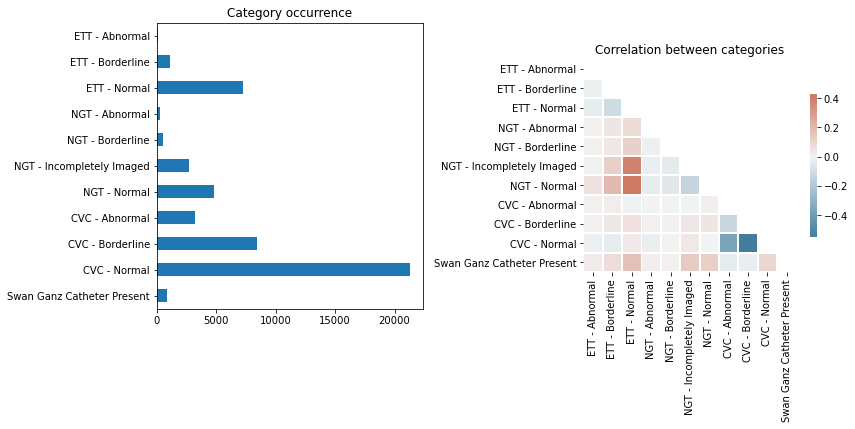

In [3]:
corr_inp = train_all_lab.drop(columns = "StudyInstanceUID").corr()
mask = np.triu(np.ones_like(corr_inp, dtype = bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
train_all_lab.drop(columns = 'StudyInstanceUID').sum().plot(kind = 'barh', ax = ax[0])
ax.ravel()[0].invert_yaxis()
ax.ravel()[0].set(ylabel = '', title = 'Category occurrence')
sns.heatmap(corr_inp, mask=mask, cmap=cmap, center=0, square=True, linewidths=1, cbar_kws={"shrink": .5}, ax = ax[1]).set_title('Correlation between categories')
fig.tight_layout()

From the left chart it becomes clear that the most common category is CVC - Normal. The abnormal categories for ETT and NGT are very rare followed by the presence of a Swan Ganz Catheter.  

There are correlations between the categories as well: The ETT (endotracheal tube) is correlated with the NGT (nasogastric tube) but without medical knowledge is hard to tell exactly why (anyone with medical knowledge please share!). 

## What are the combinations of categories present in the images?

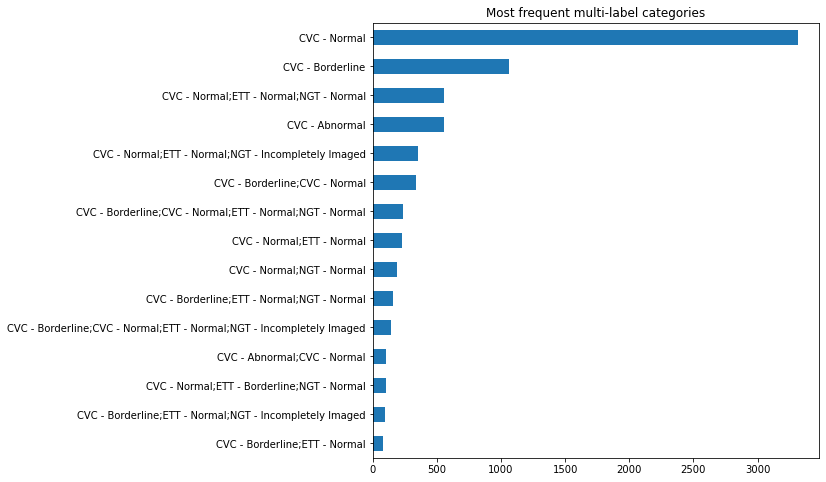

In [4]:
ax = ann.groupby('label').size().sort_values(ascending = False).head(15).plot(kind = 'barh', figsize = (8,8))
ax.invert_yaxis()
_ = ax.set(ylabel = '', title = 'Most frequent multi-label categories')

There are multiple category combinations in our dataset. Some multi-label categories include different assessments for the same type of tube (for example in category 6 "CVC-Borderline;CVC-Normal" we have two CVC categories). The reason for this could be that the patient has multiple CV catheters or that there were different assessments of the placement.

# Dataset preparation and model training

Since this notebook is about visualising the layers of the model, our batch preparation will not have any fancy augmentations.  
We will stick to resizing, simple normalisation and a very plain resnet50 model for our Learner.

In [5]:
def get_x(r): return path/'train'/r['name']
def get_y(r): return r['label'].split(';')
def get_dls(bs, size, do_flip = True, xtra_tfms = None, min_scale = 0.8):
    dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                          get_x = get_x,
                          get_y = get_y,
                          item_tfms = Resize(size),
                          batch_tfms = Normalize.from_stats(*imagenet_stats),
                          splitter = RandomSplitter(seed = 42))
    return dblock.dataloaders(ann, bs = bs)

In [6]:
set_seed(42,True)
dls = get_dls(bs = 32, size = 350)
learn = cnn_learner(dls, 
                resnet50,
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[accuracy_multi]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In order for our visualisations to be meaningful, our Learner needs to be trained for some epochs in order to get a better grasp of the data and create the necessary patterns.  
For this purpose we are going to use the lr_find method of fastai to find a suitable learning rate and then fine_tune the model for 2 epochs (one only for the very last layer and one for the whole model).

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0691830962896347)

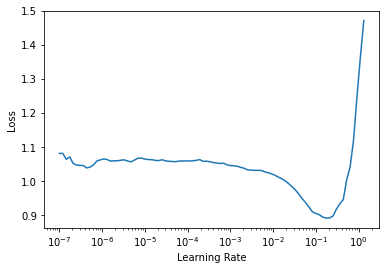

In [7]:
learn.lr_find()

Based on the figure, a learning rate around 0.03 seems to be appropriate.

In [8]:
learn.fine_tune(1, 3e-2)

# Visualising filters and feature maps

This part of the notebook focuses on the feature maps of the convolutional layers in the model.  
We are going to start out with the entry layer of the network, visualise the filters and the feature maps there.  
The next step is getting the feature map of the last convolutional layer in order to compare the two.  
Lastly, we are going to visualise how the feature maps change as we progress through the layers of the network.

## Obtaining a test patient

For our visualisations we are going to need an image to work with. I picked one from the test set and it's this one here:

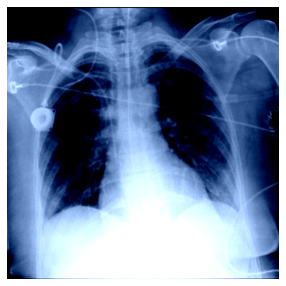

In [9]:
temp = PILImage.create('../input/ranzcr-clip-catheter-line-classification/test/1.2.826.0.1.3680043.8.498.10010309624955962953138679469906703941.jpg')
img, = first(dls.test_dl([temp]))
x_dec = TensorImage(dls.train.decode((img,))[0][0])
img = img[0]
_ = img.show()

The image is originally grayscale, but our model expects 3 channels as input and therefore all 3 channels get the same value (before normalisation).  
We can visualise this better here: 
(Notice how all three channels have the same intensity)

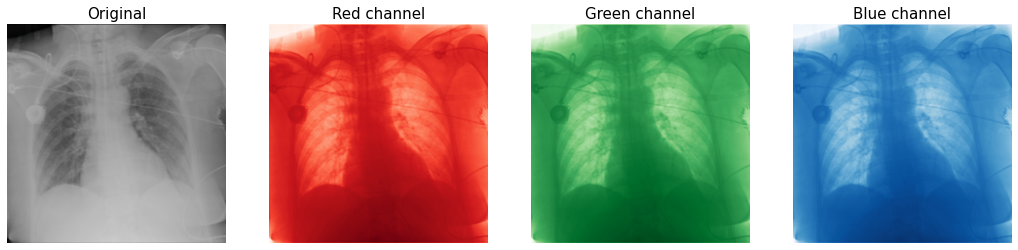

In [10]:
image_rgb = x_dec.numpy()
fig, ax = plt.subplots(1, 4, figsize = (18, 30))
ax[0].imshow(image_rgb.transpose((1,2,0))) 
ax[0].axis('off')
ax[0].set_title('Original', size = 15)
for i, cmap in enumerate(['Reds','Greens','Blues']):
    ax[i+1].imshow(image_rgb[i,:,:], cmap=cmap) 
    ax[i+1].axis('off')
    ax[i+1].set_title(cmap[:-1] + ' channel', size = 15)

## Analysing the first layer

We start with the specifications of the first layer.

In [11]:
learn.model[0][0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

A convolutional layer with the following specifications:
* Input channels: 3 - these are the 3 colors of the image we use as input 
* Output channels: 64 - the channels that will be output after the convolution
* Kernel size: 7x7 - the size of the kernel that will be applied to our images
* Stride: 2 - the step at which the kernel will be applied on the images during the convolution
* Padding: 3 - additional pixels that will be added to the sides of our image in order to not lose edge information

### Filters weights and filters

Given that we have a kernel of 7x7 and the output has 64 channels, we are going to need a matrix of size at least 64x7x7.  
But this output has to be produced for each of our input channels (we have 3) and therefore we are going to need a matrix of 64x3x7x7.
Just to double-check:

In [12]:
weights = learn.model[0][0].weight
weights.shape

torch.Size([64, 3, 7, 7])

These weights are combined into filters: Every 64x7x7 filter is comprised of the 3 filter weights that we saw before.
These filters are the patterns that the model layer is trying to find in the image.  

In [13]:
def normalise(tens):
    temp = tens.detach().cpu().numpy()
    return (255*(temp - np.min(temp))/np.ptp(temp)).astype(int)   

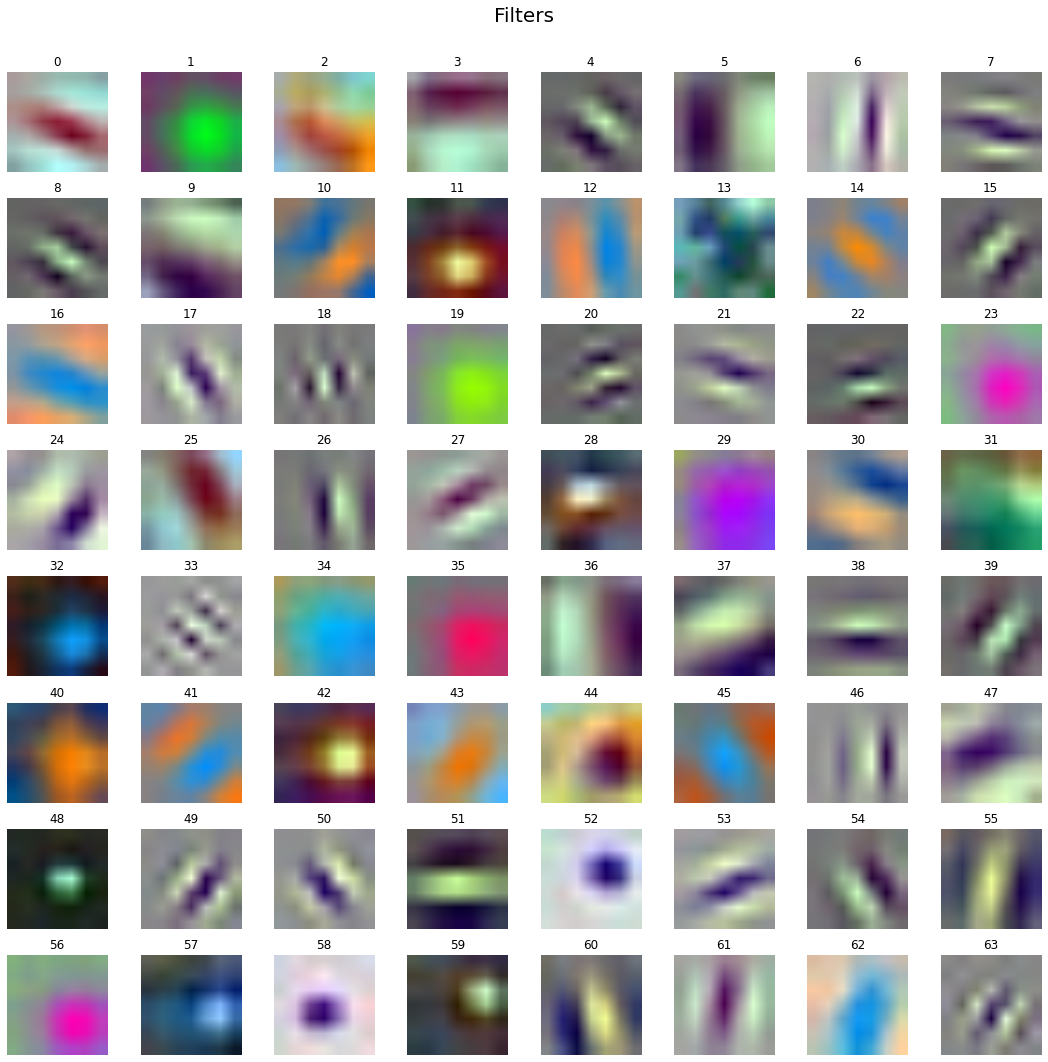

In [14]:
fig,axes = plt.subplots(8, 8, figsize=(15,15))
for i in range(64):
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(normalise(weights[i].permute(1,2,0)), interpolation = 'bilinear')
    axes.ravel()[i].set_title(i)
fig.suptitle('Filters', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

We can see that the first layer is mainly looking for finding edges (diagonal, horizontal or vertical) as well as areas where one or two colors are more prevalent in the data.  
What do the colors mean in the plot? Remember the 3 channels that we had (R, G, B). The filters that are green are more focused on the green channel of our input, the filters that are red on the red channel etc. The yellow images for example are more focused on the red and green channels compared to the blue one.
Let us have a look at one of the yellow images to see if the underlying weight tensor justifies our beliefs.

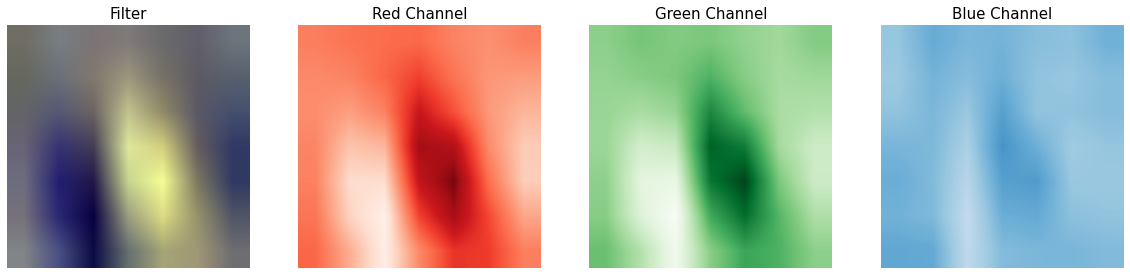

In [15]:
vmax_weights, vmin_weights = weights[60].max(), weights[60].min()
fig, ax = plt.subplots(1, 4, figsize = (20, 20))
ax[0].imshow(normalise(weights[60].permute(1,2,0)), interpolation = 'bilinear') 
ax[0].axis('off')
ax[0].set_title('Filter', size = 15)
for i, cmap in enumerate(['Reds','Greens','Blues']):
    ax[i+1].imshow(weights[60].detach().cpu().numpy()[i,:,:], cmap=cmap, vmin = vmin_weights, vmax = vmax_weights, interpolation = 'bilinear') 
    ax[i+1].axis('off')
    ax[i+1].set_title(cmap[:-1] + ' Channel', size = 15)


The images show that the red and green channels are more intense in the bottom right quadrant than the blue one and that is how the yellow filter gets produced.  
On the other hand the bottom left quadrant is more intense for the blue channel and therefore the blue color is more pronounced in that area of the filter.

An important question I had when writing this kernel is the following: The input of the model is using the same values in each of the 3 input channels, how does it manage to have different filters for each channel? My expectation would be that they would be the same. There are 3 parameters in play:
1. Pretraining. The model we are using (resnet50) has been trained on the Imagenet dataset (which has colored pictures) and while the weights do get updated by our training, there is always residual
2. Image normalization with Imagenet stats. The starting image has the same values in all 3 channels but the normalisation changes this to some extent

### Time to get some hooks in!

Pytorch hooks are great in order to get a better understanding of the internal operations of a model.  
There are 2 types of hooks available:
* Forward hooks (also a forward -pre hook but we are not going to touch on that)
* Backward hooks  

The main properties of hooks are:
1. They can be attached to a specific layer of the model 
2. They have access to the input and output of that particular layer
3. They are triggered/executed when either the forward pass of that layer takes place (forward hook) or when the backward pass takes place (backward hook)
4. You can attach to them custom functions that can use the data of the hook layer

### Baby steps - Hooking the first convolutional layer

In [16]:
class fHook():
    def hook_f(self, module, inp, out): 
        self.inp_stored = inp
        self.out_stored = out.detach().clone()

In [17]:
hook_data = fHook() # Creating an instance of the hook
hook_new = learn.model[0][0].register_forward_hook(hook_data.hook_f) # Attaching it to the first layer of the model
with torch.no_grad(): output = learn.model.eval()(img.unsqueeze(0)) # Propagating an image through the network to get all the layers working
hook_new.remove() # Removing the hook

Having hooked the first layer, we have access now to the input and output of the layer.  
**Important point: the input of the layer is stored as a tensor inside a tuple while the output is a tensor!**

In [18]:
hook_data.inp_stored[0].shape, hook_data.out_stored.shape, 

((1, 3, 350, 350), (1, 64, 175, 175))


Did we expect these inputs and outputs?  
**Yes!**    
* The input of the first layer in our network is the image we passed to our model converted to a tensor and resized to 350 pixels (1x3x350x350).  

The output (1x64x175x175) can be explained as follows:
* The 1 at the first dimension of the tensor is the number of inputs (1 image --> 1 input) 
* 175x175 is the size of the output image and it can be derived from the original input size (350) via the following equation: $ \text{output size} = (\text{input size} + 2*\text{padding} - \text{kernel size}) // \text{stride} + 1 $. Substituting our figures we end up with: $(350 + 2*3 - 7) // 2 + 1 = 349 // 2 + 1 = 174 + 1 = 175$  
* The 64 is a bit trickier than it looks:  
  We started out with 3 channels and we used filter weights of 64x3x7x7, therefore one would expect the output not to be 64 but to be 64x3.  
  The hidden calculation here is that after we derive the 64 outputs for each of the 3 channels we had as input, we add them together!


| ![Final addition](https://raw.githubusercontent.com/fastai/fastbook/8be580737ee0cc17746a5ed68283150d489b3dc4/images/chapter9_rgb_conv_stack.svg) | 
|:--:| 
| *Image taken from fastbook https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb* |

**Sanity checks for our hook results:**
1. The input from the hook is exactly equal to the input tensor
2. The output is the result of doing a convolution between the input image and the filter weights

In [19]:
print('Sanity check 1: ' + str(torch.equal(img.unsqueeze(0), hook_data.inp_stored[0])))
print('Sanity check 2: ' + str(torch.equal(F.conv2d(img.unsqueeze(0), weights, padding = 3, stride = 2), hook_data.out_stored)))

Sanity check 1: True
Sanity check 2: True


### Feature maps

Feature maps highlight the patterns that the filters managed to find in the input. 

In [20]:
fm = hook_data.out_stored

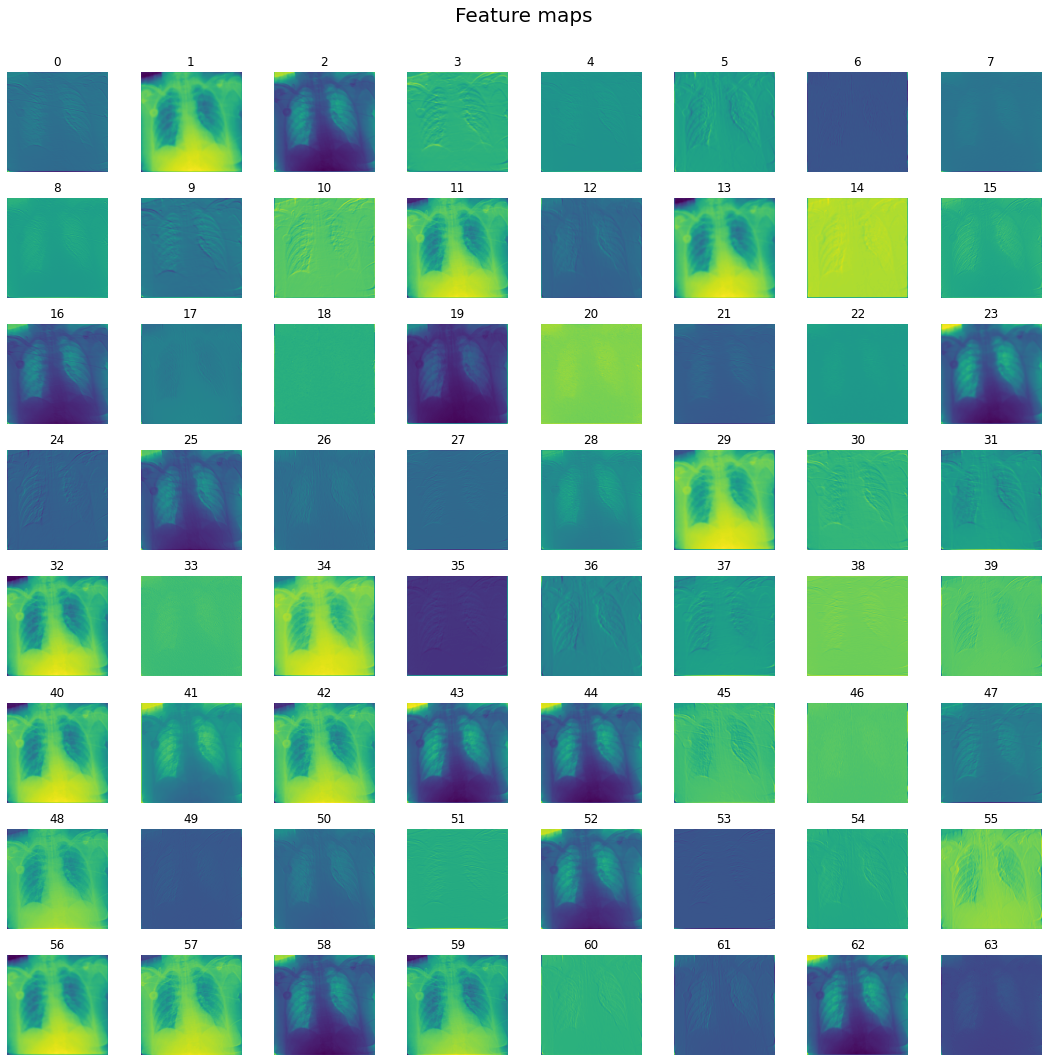

In [21]:
fig,axes = plt.subplots(8, 8, figsize=(15,15))
for i in range(64):
    axes.ravel()[i].imshow(fm[0][i].detach().cpu(), interpolation='bilinear')
    axes.ravel()[i].axis('off')
    axes.ravel()[i].set_title(i)
fig.suptitle('Feature maps', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

These are the activations of the first layer. The output of convolving our original image with the weights we visualized earlier.  
**Important note: The color of the image reflects how high (or low) a pixel value is in comparison to the other pixels in the same picture. As an example in picture 1, the really light pixels have a high value in comparison to the dark pixels.**

There are some interesting patterns in the pictures:
* The original image is still clearly visible in the result of the convolution
* If a filter pattern gets discovered the particular areas where it gets discovered will show up lighter in the images. This does not mean that the filters which are uniform as useless, it simply means that for this **particular image** their patterns are not present!

### One step further - Hooking the last convolutional layer

In [22]:
hook_data = fHook() # Creating an instance of the hook
hook_new = learn.model[0][-1].register_forward_hook(hook_data.hook_f) # Attaching it to the last layer of the model
with torch.no_grad(): output = learn.model.eval()(img.unsqueeze(0)) # Propagating an image through the network to get all the layers working
hook_new.remove() # Removing the hook

The last convolutional layer is comprised of 3 Bottleneck constructions but the final output is the result of a convolutions(512, 2048) followed by a BatchNorm2d(2048) and then a ReLU (all belonging to the last Bottleneck).

In [23]:
learn.model[0][-1][-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

It is always good to double-check our expectations. The output size should have 2048 channels.

In [24]:
fm_last = hook_data.out_stored
fm_last.shape

(1, 2048, 11, 11)

Now that we have checked the output size, let's have a look at some feature maps. Given that there are 2048 of them it would be pretty tough to view all of them at once so we will stick to a random sample of 64:

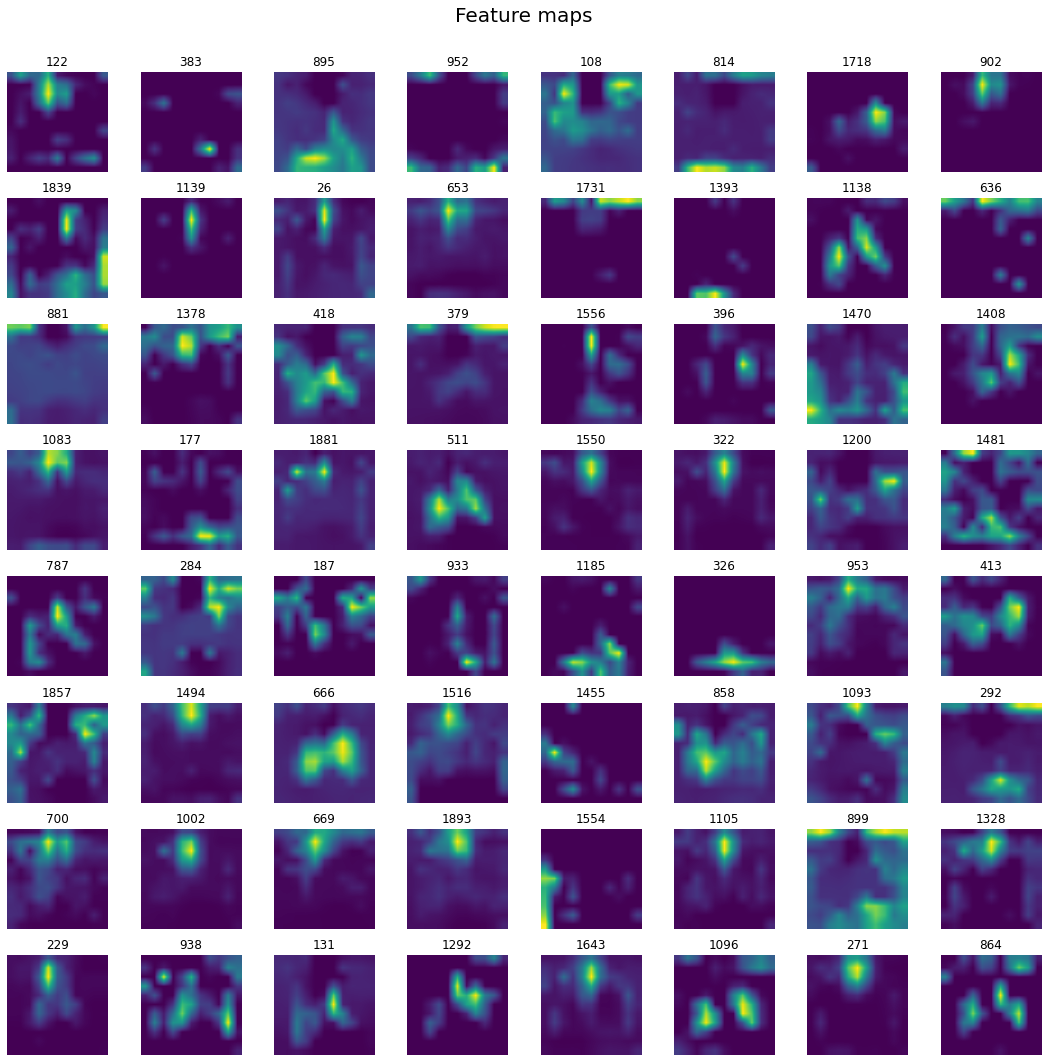

In [25]:
sample64 = random.sample(range(2048), 64)
fig,axes = plt.subplots(8, 8, figsize=(15,15))
for i,ind in enumerate(sample64):
    axes.ravel()[i].imshow(fm_last[0][ind].detach().cpu(), interpolation='bilinear')
    axes.ravel()[i].axis('off')
    axes.ravel()[i].set_title(ind)
fig.suptitle('Feature maps', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

I think it is pretty conclusive that after all the layers and transformations the image has gone through it is pretty hard to distinguish any resemblance to our original lovely skeleton.

## How do the convolutions change as we progress through the network?
So far we have seen how the feature maps at the first convolutional layer look like as well as the output (after a batchnorm and ReLu) of the last convolutional layer. 
But how do the outputs change from layer to layer?  
We can only answer this question by hooking every convolutional layer in the model!

In [26]:
conv_out = []
hook_data = fHook()
for layer in learn.model.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        hook_handler = layer.register_forward_hook(hook_data.hook_f)
        with torch.no_grad(): output = learn.model.eval()(img.unsqueeze(0))
        conv_out.append(hook_data.out_stored[0])
        hook_handler.remove()
        

Before we delve deeper into the feature maps, it's good to get a basic understanding of what types of layers are present in the model.  

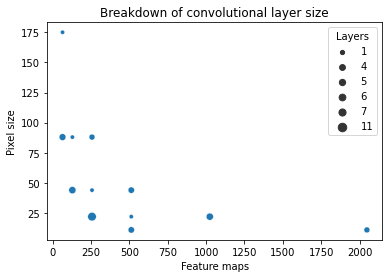

In [27]:
cv_sizes = pd.DataFrame([(x.shape[0], x.shape[1]) for x in conv_out])
cv_sizes.columns = ['Feature maps', 'Pixel size']
cv_sizes = cv_sizes.groupby(['Feature maps', 'Pixel size']).size().to_frame('Layers').reset_index()
_ = sns.scatterplot(x = cv_sizes['Feature maps'], y = cv_sizes['Pixel size'], size = cv_sizes['Layers'])
_ = plt.title('Breakdown of convolutional layer size')

The majority of the layers have 250 activations with a pixel size of 25, but there are plenty of combinations available in the model.  

In order to better visualise how the feature maps change as we go deeper into the network we are going to use an animation showcasing a sample of 15 feature maps at each convolutional layer of the model. This will give a better representation of how the evolution from the clear feature maps of the first layer to the unrecognizeable ones of the last one happens.

In [28]:
fig, ax = plt.subplots(3, 5, figsize=(5,3), dpi = 150)
title = plt.suptitle(t='', fontsize = 12, family = 'fantasy')
fig.subplots_adjust(top=0.92)

def animate_tensors(i, pic_num = 15):
    tens = conv_out[i]
    
    tens_positions = random.sample(range(tens.shape[0]), pic_num)
    to_plot_maps = tens[tens_positions]
    
    for j in range(pic_num):
        ax.ravel()[j].imshow(to_plot_maps[j].detach().cpu(), interpolation='bilinear')
        ax.ravel()[j].axis('off')
        title.set_text('Feature map {}'.format(i))
        plt.tight_layout()

anim = animation.FuncAnimation(fig, animate_tensors, frames= len(conv_out), interval=1500, repeat=True)

plt.close()
HTML(anim.to_html5_video())

<Figure size 432x288 with 0 Axes>

I stop being able to see anything relatable to the original picture at around Feature map 25. What about you? 🤔

# Working backward from output classes to activations - Grad CAM

Another type of visualisation we can try is the following:
Our model predicts category X for this image. On which areas of the image did the model focus on for obtaining that prediction?

In order to address this question, we are going to implement the Grad-CAM that was first suggested in this paper: [Grad-CAM paper](https://arxiv.org/abs/1610.02391)

More specifically, we are going to: 
1. Use a forward hook in order to get the activations of the last layer in the convolutional part of the resnet
2. Use a backward hook in order to get the gradients of the layer

## Simple approach

In [29]:
class fHook():
    def hook_fwd_f(self, module, inp, out): 
        self.out_stored = out.detach().clone()
        
class bHook():
    def hook_bwd_f(self, module, inp, out):
        self.out_stored = out[0].detach().clone()    

In [30]:
## Forward hook
fwd_hook = fHook()
fwd_handler = learn.model[0].register_forward_hook(fwd_hook.hook_fwd_f)
learn.model.eval()(img.unsqueeze(0))
act = fwd_hook.out_stored #Storing the activation
fwd_handler.remove()

## Backward hook
grads = []
bwd_hook = bHook()
for cls in range(11):
    bwd_handler = learn.model[0].register_backward_hook(bwd_hook.hook_bwd_f)
    output = learn.model.eval()(img.unsqueeze(0))
    output[0,cls].backward()
    grads.append(bwd_hook.out_stored) #Storing the gradients
    bwd_handler.remove()

The forward part of the code is exactly the same as before. We simply store the activation.  

The backward part is different. We are using a for loop in order to calculate the gradients for each of the output classes that we have in the data (the 11 categories of our images).  
This is needed because the grad can only be created for **scalar outputs**. In simple terms this means that PyTorch can calculate the backwards gradient only for each individual class.  
Therefore, we do the same process for all 11 of our categories and store them.

## More complicated but better approach

The below implementation is taken from this chapter in the fastai course: [Chapter 18 fastai](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb). The logic is to turn the hooks into a context manager.  
Essentially, this approach allows the Hook classes to be used in a with statement without having to remove them manually afterwards. Simply hook the layer, get the data and after you are done the Hook will remove itself. For more details about context managers have a look [here](https://stackoverflow.com/questions/1984325/explaining-pythons-enter-and-exit)

In [31]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [32]:
grads = []
for cls in range(11):
    with HookBwd(learn.model[0]) as hookb:
        with Hook(learn.model[0]) as hookf:
            output = learn.model.eval()(img.unsqueeze(0))
            act = hookf.stored
        output[0,cls].backward()
        grads.append(hookb.stored)

After obtaining the activation and the gradients of the layer of interest, we need to multiply them together in order to derive the Grad-CAM values. 
My understanding of the process is the following:  
* The gradients are representing how important each activation pixel is for a particular class
* The activation is representing how activated each individual pixel is.  
**Multiplying them together shows which of the important class pixels are activated.**

After the multiplication, we apply also a ReLU function. The reasoning behind this choice (from the paper on Grad-CAM):
*We apply a ReLU to the linear combination of maps because we are only interested in the features that have a positive influence on the class of interest*

In [33]:
cam_maps = []
for i in range(11):
    w = grads[i][0].mean(dim=[1,2], keepdim = True)
    cam_maps.append(F.relu((w*act[0]).sum(0)))

In [34]:
top_preds, top_ind= torch.topk(learn.model.eval()(img.unsqueeze(0)).sigmoid()[0], 4)
top_preds = np.round(top_preds.detach().cpu().detach().numpy(), 2)
top_ind = top_ind.tolist()

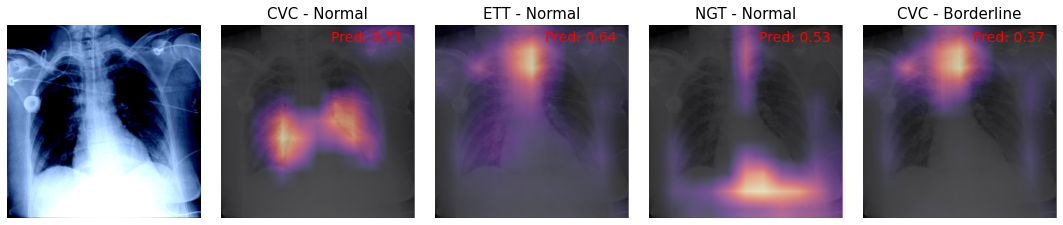

In [35]:
fig,ax = plt.subplots(1,5, figsize = (15,10))
for i, ind in enumerate(top_ind, start = 1):
    x_dec.show(ctx = ax.ravel()[i])
    ax.ravel()[i].imshow(cam_maps[ind].detach().cpu(), alpha = 0.6, extent = (0,350,350,0), interpolation = 'bilinear', cmap = 'magma')
    ax.ravel()[i].set_title(learn.dls.vocab[ind], size = 15)
    ax.ravel()[i].text(200,30,'Pred: ' + str(top_preds[i-1]), color = 'red', size = 14)

img.show(ctx = ax.ravel()[0])
fig.tight_layout()

The visualisations show exactly the areas that our model focuses on for each of the prediction classes. (Only the top 4 predicted classes are shown)  
For example, for the category **'CVC Normal'** the focus of the model is on the **central chest area**.  
On the other hand, for the **'ETT - Normal'** prediction, the focus is more narrowly on the area **around the throat**.   
The **'NGT-Normal'** prediction is more spread out but the intense part is on the bottom right.  
*Note that this is a multi-label classification problem therefore the predictions do not sum to 1 as in the single-label case.*

# Resources

### Papers
Learning Deep Features for Discriminative Localization: https://arxiv.org/abs/1512.04150  
Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization: https://arxiv.org/abs/1610.02391

### Hook related resources
Fastai notebook: https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb  
Understanding PyTorch hooks (kaggle kernel): https://www.kaggle.com/sironghuang/understanding-pytorch-hooks  
PyTorch documentation: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks  
Paperspace article: https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/  
Youtube video: https://www.youtube.com/watch?v=syLFCVYua6Q

### Matplotlib animations
Matplotlib documentation: https://matplotlib.org/stable/api/animation_api.html

### Context manager
Python 3 documentation: https://docs.python.org/3/reference/datamodel.html#with-statement-context-managers  
Stackoverflow answer: https://stackoverflow.com/questions/1984325/explaining-pythons-enter-and-exit


If you enjoyed this notebook, liked the visualisations, have questions/suggestions or comments please let me know!! And if you feel like it, give it an upvote 😊😊✨✨